In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
def _pad_to_common_shape(img):
    if(len(img.shape) == 3):
        return np.pad(img, [[1280 - img.shape[0], 0], [0, 0], [0, 0]])
    elif(len(img.shape) == 2):
        return np.pad(img, [[1280 - img.shape[0], 0], [0, 0]])

In [5]:
# Given pnaoptic predictions of five cameras at a certain timestamp,
# we want to make the instance ID across 5 cameras to be consistent
context_name = "9243656068381062947_1297_428_1317_428"
pred_path = f'../{context_name}'
image_path = f'/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_jpg/validation/{context_name}'

cam_extrinsic = np.load('./Parameters/Camera_Param/cam_extrinsic.npy')# shape (5, 4, 4)
cam_intrinsic = np.load('./Parameters/Camera_Param/cam_intrinsic.npy')# shape (3, 4, 4)
cam_distortion = np.load('./Parameters/Camera_Param/cam_distortion.npy') # k1, k2, p1, p2, k3

cam_dict = {
    "img_FRONT" : 0,
    "img_FRONT_LEFT" : 1,
    "img_FRONT_RIGHT" : 2,
    "img_SIDE_LEFT" : 3,
    "img_SIDE_RIGHT" : 4
}

# n1 should be to the left of n2
n1 = "FRONT"
n2 = "FRONT_RIGHT"

cam_name1 = f"img_{n1}"
cam_name2 = f"img_{n2}"

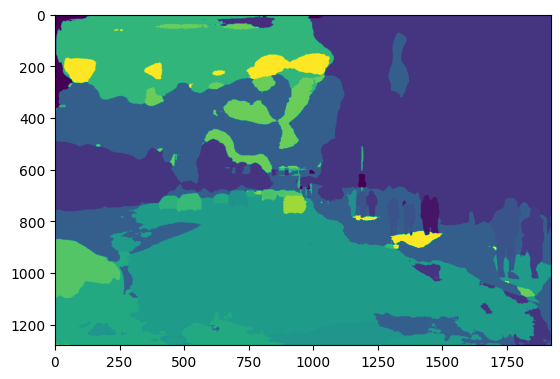

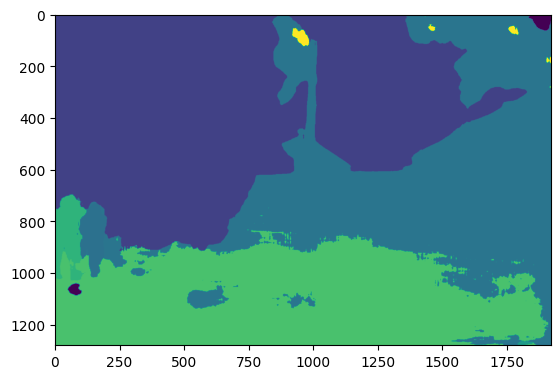

=================Found  4534  in the left semantic cnts: 3309
These panoptic_id2 is the candidate to compute IoU
[4070 4344 4439 4534 4566]
-------candidate 4070 IoU:  0.0003022061045633122
-------candidate 4344 IoU:  0.0009066183136899365
-------candidate 4439 IoU:  0.0015110305228165609
-------candidate 4534 IoU:  0.9969779389543669
-------candidate 4566 IoU:  0.0003022061045633122
4534  and  4534  are the same objects!!!!!!!!!!
=================Found  35142  in the left semantic cnts: 168854
These panoptic_id2 is the candidate to compute IoU
[34903 34963 35076 35142]
-------candidate 34903 IoU:  5.922276049131202e-06
-------candidate 34963 IoU:  5.922276049131202e-06
-------candidate 35076 IoU:  5.922276049131202e-06
-------candidate 35142 IoU:  0.9999822331718526
35142  and  35142  are the same objects!!!!!!!!!!
=================Found  41033  in the left semantic cnts: 1
These panoptic_id2 is the candidate to compute IoU
[28832]
-------candidate 28832 IoU:  1.0
=================Fou

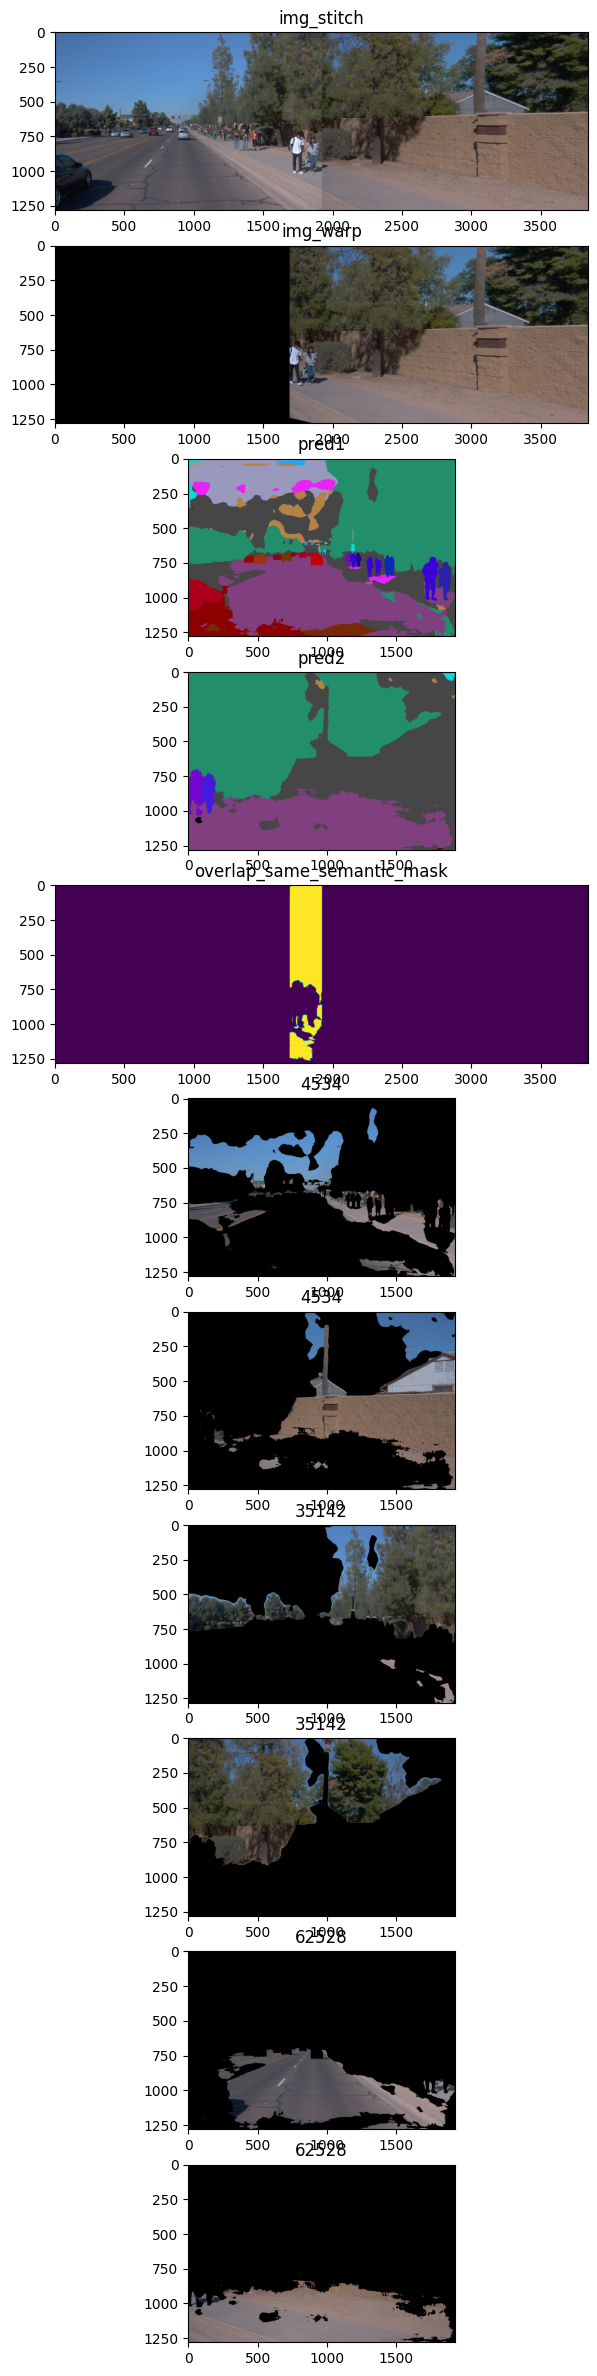

In [6]:
def warpImage(img1, img2, H, addImg1=False):
    # Given two imgs and Homography between them, output an img_stitch that stitches them together
    img_stitch = cv2.warpPerspective(img2, H, (img2.shape[1]*2, img2.shape[0]))
    if(addImg1):
        img_stitch[0:img1.shape[0], 0:img1.shape[1]] = img1
    return img_stitch

def computeIoU(mask1, mask2):
    return np.sum(np.logical_and(mask1, mask2)) / np.sum(np.logical_or(mask1, mask2))

time_stamps = [f for f in os.listdir(pred_path) if os.path.isdir(os.path.join(pred_path, f))]
time_stamps = sorted(time_stamps)
curious_timestamp = 0 # Specify which timestamp we're curious about
for i, time_stamp in enumerate(time_stamps):
    if(i == curious_timestamp):
        # fetch predictions from VipDeepLab, construct into semantic_pred, instance_pred, and panoptic_pred
        pred1 = cv2.imread(f"{pred_path}/{time_stamp}/{cam_name1}_panoptic_prediction.png")
        img1 = cv2.imread(f"{image_path}/{time_stamp}/{cam_name1}.jpg")
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        semantic_pred1 = pred1[:, :, 0]
        instance_pred1 = pred1[:, :, 1]
        panoptic_pred1 = semantic_pred1 * 1000 + instance_pred1
        img1 = _pad_to_common_shape(img1)
        semantic_pred1 = _pad_to_common_shape(semantic_pred1)
        
        pred2 = cv2.imread(f"{pred_path}/{time_stamp}/{cam_name2}_panoptic_prediction.png")
        img2 = cv2.imread(f"{image_path}/{time_stamp}/{cam_name2}.jpg")
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        semantic_pred2 = pred2[:, :, 0]
        instance_pred2 = pred2[:, :, 1]
        panoptic_pred2 = semantic_pred2 * 1000 + instance_pred2
        img2 = _pad_to_common_shape(img2)
        semantic_pred2 = _pad_to_common_shape(semantic_pred2)
        
        # Fetch the presaved homography (already tuned to be best for each pair of camera)
        H = np.load(f"./Parameters/Homography/H_{n1}_and_{n2}.npy")
        
        # stitch semantic predictions, only the right part is preserved
        semantic_warp = warpImage(semantic_pred1, semantic_pred2, H, addImg1=False) 
        
        # stitch panoptic predictions, only the right part is preserved
        panoptic_warp = warpImage(panoptic_pred1, panoptic_pred2, H, addImg1=False)
        
        # stitch original image (just for better visualization)
        img_stitch = warpImage(img1, img2, H, addImg1=True) # two imgs stitched
        img_warp = warpImage(img1, img2, H, addImg1=False) # only the right part is preserved
        
        
        reassignIDList = []
        
        # compute the warped top-left-corner and bottom-left-corner of img2
        tl = H @ np.array([0, 0, 1])
        tl /= tl[2]
        bl = H @ np.array([0, img2.shape[0], 1])
        bl /= bl[2]
        
        # Overlapped mask: between left_most_of_warpedImg2 and right_most_of_img1
        left_most_of_warpedImg2 = np.floor(min(tl[0], bl[0])).astype(int)
        right_most_of_img1 = img1.shape[1]
        overlap_mask = np.zeros_like(semantic_warp)
        overlap_mask[:, left_most_of_warpedImg2:right_most_of_img1] = 1
        
        # sem_overlap1: semantic predictions of img1 in the overlapped area
        # sem_overlap2: semantic predictions of img2 in the overlapped area
        sem_overlap1 = np.zeros_like(semantic_warp)
        sem_overlap1[:, left_most_of_warpedImg2:right_most_of_img1] = semantic_pred1[:, left_most_of_warpedImg2:right_most_of_img1]
        sem_overlap2 = np.zeros_like(semantic_warp)
        sem_overlap2[:, left_most_of_warpedImg2:right_most_of_img1] = semantic_warp[:, left_most_of_warpedImg2:right_most_of_img1]
        
        # panoptic_pred1_long: panoptic predictions of img1, but expand to long shape
        # panoptic_pred2_long: panoptic predictions of img2, but expand to long shape
        panoptic_pred1_long = np.zeros_like(panoptic_warp)
        panoptic_pred1_long[:img1.shape[0], :img1.shape[1]] = panoptic_pred1
        panoptic_pred2_long = panoptic_warp
        
        plt.imshow(semantic_pred1)
        plt.show()
        plt.imshow(semantic_pred2)
        plt.show()
        
        # overlap_same_semantic_mask: see what are the pixels in the overlapped region that has the
        # same semantic predictions for img1 and img2
        overlap_same_semantic_mask = sem_overlap1 == sem_overlap2
        overlap_same_semantic_mask[overlap_mask == 0] = 0
        
        # Among those same semantic pixels in the overlapped area, we're interested in their panoptic ID (what class and instance they are)
        # panoptoc1_unique_ids are all the object we're interested in.
        # We iterate each of those objects:
        # overlap_same_sem1_certain_pano_id_mask is the mask where the object appears in the overlapped area
        # Then, we apply this mask to panoptic_pred2_long, to see what are the objects in img2 that appear in this mask.
        # After we found the candidates im img2, we compute IoU between them and the panoptic1_id.
        # Whoever has the highest and IoU and above certain threshold, we consider them the same instance.
        panoptic1_unique_ids, panoptic1_unique_ids_cnts = np.unique(panoptic_pred1_long[overlap_same_semantic_mask], return_counts=True)
        # We iterate each of those objects:
        for i, panoptic1_id in enumerate(panoptic1_unique_ids):
            area_in_panoptic1 = panoptic1_unique_ids_cnts[i]
            print("=================Found ",panoptic1_id, " in the left semantic cnts:", area_in_panoptic1)
            
            overlap_same_sem1_certain_pano_id_mask =  np.logical_and(overlap_same_semantic_mask, (panoptic_pred1_long == panoptic1_id))
            m = (panoptic_pred1_long == panoptic1_id)
            # for this certain panoptic1_id, we want to find every panoptic2_ids that appears within this area, for each
            # of them, compute the IoU. If IoU is big, it means panotic1_id is the same object as that specific panoptic2_id,
            # So we reassign the instance2_id[pantopic_pred == panoptic2] = instance1_id
            panoptic2_ids, panoptic2_ids_cnts = np.unique(panoptic_pred2_long[overlap_same_sem1_certain_pano_id_mask], return_counts=True)
            print("These panoptic_id2 is the candidate to compute IoU")
            print(panoptic2_ids)
            max_iou = 0
            best_panoptic2 = None
            for panoptic2_id in panoptic2_ids:
                overlap_same_sem2_certain_pano_id_mask = np.logical_and(overlap_same_semantic_mask, (panoptic_pred2_long == panoptic2_id))
#                     print(overlap_same_sem2_certain_pano_id_mask.sum())
#                     plt.imshow(overlap_same_sem2_certain_pano_id_mask)
#                     plt.show()
                iou = computeIoU(overlap_same_sem1_certain_pano_id_mask, overlap_same_sem2_certain_pano_id_mask)
                print("-------candidate", panoptic2_id, "IoU: ",iou)
                if(iou > max_iou):
                    max_iou = iou
                    best_panoptic2 = panoptic2_id
            if(max_iou > 0.7 and area_in_panoptic1 > 100):
                # replace!!
                print(panoptic1_id, " and ", best_panoptic2, " are the same objects!!!!!!!!!!")
                reassignIDList.append([panoptic1_id, best_panoptic2])
        
        
        print("Our reassignIDList!")
        print(reassignIDList)
        fig, axs = plt.subplots(2*len(reassignIDList)+2+2+1, 1, figsize=(10, 30))
        
        axs[0].imshow(img_stitch)
        axs[0].set_title('img_stitch')
        
        axs[1].imshow(img_warp)
        axs[1].set_title('img_warp')
        
        axs[2].imshow(pred1)
        axs[2].set_title('pred1')
        
        axs[3].imshow(pred2)
        axs[3].set_title('pred2')
        
        axs[4].imshow(overlap_same_semantic_mask)
        axs[4].set_title("overlap_same_semantic_mask")
        
        for i, [panoptic1_id, panoptic2_id] in enumerate(reassignIDList):
            instance_pred2[panoptic_pred2 == panoptic2_id] = instance_pred1[panoptic_pred1 == panoptic1_id][0]
            img1_mask = np.zeros_like(img1)
            img2_mask = np.zeros_like(img2)
            for j in range(3):
                img1_mask[:, :, j] = panoptic_pred1 == panoptic1_id
                img2_mask[:, :, j] = panoptic_pred2 == panoptic2_id
                
            axs[2*i+5].imshow(img1 * img1_mask)
            axs[2*i+5].set_title(panoptic1_id)
            axs[2*i+6].imshow(img2 * img2_mask)
            axs[2*i+6].set_title(panoptic2_id)
        


plt.show()

In [4]:
a = panoptic_pred1 == panoptic1_id
print(a.shape)
b = np.hstack((a, a, a))
print(b.shape)

(1280, 1920)
(1280, 5760)
